# Twitter üzerinde Duygu Analizi
Yunus Emre Gündoğmuş - 6 Eylül 2021

### Referanslar
- [How to Scrape Tweets From Twitter](https://towardsdatascience.com/how-to-scrape-tweets-from-twitter-59287e20f0f1)
- [Savaş Yıldırım - Bert-base Turkish Sentiment Model](https://huggingface.co/savasy/bert-base-turkish-sentiment-cased)

### Kütüphalerin İçeri Alınması

In [ ]:
!pip install transformers
!pip install tweepy
!pip install tqdm

!pip install wordcloud
!pip install TurkishStemmer
!pip install sklearn
!pip install nltk

In [1]:
# Twitter API
import tweepy

# Data Manipulation
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

# Bert Model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Metin Ön İşleme
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings(action = 'ignore')

import requests

### Twitter API Ayarlarının Yapılması

In [2]:
# API için Keyler
# API link: https://developer.twitter.com/en/apps

consumer_key = 'yoIwFkjZGYDa49aO16XqSNqcN'
consumer_secret = 'gl4LQOItV7Z1aFwNrlvaiKJ3t8o8h99blMIAmnmdHxYjzjRAxO' 
access_token = '624310916-E7fDF2IE8P6bfY1oVFglASf6F8RnxMd3vgSXFqnZ'
access_token_secret ='ID9JcoXHsDcKtvNcnmBGcCQhUlO0wmwAxBJ6LCesiUAas'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Korona Anahtar kelimesindeki 100 tweet'in çekilmesi

In [3]:
tweets_list = []
text_query = 'Korona'
count = 100

for tweet in api.search(q=text_query, count=count, lang='tr-tr'):
    tweets_list.append((tweet.created_at,tweet.id,tweet.text))

In [4]:
tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
tweets.head()

,Tarih,Tweet_id,Text
0,2021-09-06 21:32:53,1434993027454488576,RT @fenomen_2014: Okul açılmış\nYakınımızdaki ...
1,2021-09-06 21:32:37,1434992959733354498,"RT @yusdemoz: Kişi, spor salonu üyesi ve koron..."
2,2021-09-06 21:32:36,1434992956335927297,RT @duru94041945: Kardeşim okuldan geldi dediğ...
3,2021-09-06 21:32:35,1434992954914058251,RT @mertjustin: Korona aşısı olmamak için tekl...
4,2021-09-06 21:32:24,1434992905761042433,RT @tweetymivity: Yüz yüze eğitim zorunluluğun...


### Eğitilmiş BERT Modeli Kullanarak Duygu Analizinin Yapılması

In [5]:
# Eğitilmiş Ağırlıkların Yüklenmesi
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [6]:
sentiment_analysis_pipeline("Çok güzel bir film olduğunu düşünüyorum")

[{'label': 'positive', 'score': 0.9875534176826477}]

In [7]:
sentiment_result=[]
for text in tqdm(tweets.Text):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.27it/s]


In [8]:
sentiment_result = pd.DataFrame(sentiment_result)
sentiment_result.head()

,label,score
0,positive,0.796184
1,negative,0.899083
2,negative,0.880791
3,negative,0.862463
4,positive,0.820187


In [9]:
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([tweets, sentiment_result],axis=1)
tweets.label = tweets.label.map({'positive':1,'negative':0})
tweets.head()

,Tarih,Tweet_id,Text,label,score
0,2021-09-06 21:32:53,1434993027454488576,RT @fenomen_2014: Okul açılmış\nYakınımızdaki ...,1,0.796184
1,2021-09-06 21:32:37,1434992959733354498,"RT @yusdemoz: Kişi, spor salonu üyesi ve koron...",0,0.899083
2,2021-09-06 21:32:36,1434992956335927297,RT @duru94041945: Kardeşim okuldan geldi dediğ...,0,0.880791
3,2021-09-06 21:32:35,1434992954914058251,RT @mertjustin: Korona aşısı olmamak için tekl...,0,0.862463
4,2021-09-06 21:32:24,1434992905761042433,RT @tweetymivity: Yüz yüze eğitim zorunluluğun...,1,0.820187


### Hepsini Bir araya Getirelim

In [10]:
class TwitterSentimentAnalyser:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, keyword, tweetCount):
        self.keyword = keyword
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        self.tweetCount = tweetCount
        
    def getTwitterData(self):
        tweets_list = []
        
        for tweet in api.search(q=self.keyword, count=self.tweetCount, lang='tr-tr'):
            tweets_list.append((tweet.created_at,tweet.id,tweet.text))
            
        self.tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
            
    def bertPipeline(self):
        # Eğitilmiş Ağırlıkların Yüklenmesi
        model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
        tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

        self.sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
        
    def sentimentPrediction(self):
        self.sentiment_result=[]
        for text in tqdm(self.tweets.Text):
            result = sentiment_analysis_pipeline(text)[0]
            self.sentiment_result.append(result)
        
        self.sentiment_result = pd.DataFrame(self.sentiment_result)
        self.tweets = pd.concat([self.tweets, self.sentiment_result],axis=1)
        self.tweets.label = self.tweets.label.map({'positive':1,'negative':0})

In [11]:
twst = TwitterSentimentAnalyser(consumer_key = consumer_key, consumer_secret = consumer_secret,
                                access_token = access_token, access_token_secret = access_token_secret,
                                keyword='dolar', tweetCount=100)

In [12]:
twst.getTwitterData()
twst.tweets.head()

,Tarih,Tweet_id,Text
0,2021-09-06 21:33:10,1434993097939771398,"RT @TUBAparody: O kadar yangın çıktı, sel oldu..."
1,2021-09-06 21:32:46,1434992997419081728,@kriptoemre 128 milyar dolar 😇
2,2021-09-06 21:32:29,1434992927038640128,"RT @__TESTERE_____: Giriş:\nİşte, bütün servet..."
3,2021-09-06 21:32:29,1434992926040498182,"@kriptoemre Parayla zaman satın alınmazki, 5mi..."
4,2021-09-06 21:32:19,1434992887771639812,@allbeganoneday Süper 2 dolar olck


In [13]:
twst.bertPipeline()

In [14]:
twst.sentimentPrediction()
twst.tweets.head()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.08it/s]


,Tarih,Tweet_id,Text,label,score
0,2021-09-06 21:33:10,1434993097939771398,"RT @TUBAparody: O kadar yangın çıktı, sel oldu...",0,0.994194
1,2021-09-06 21:32:46,1434992997419081728,@kriptoemre 128 milyar dolar 😇,1,0.989131
2,2021-09-06 21:32:29,1434992927038640128,"RT @__TESTERE_____: Giriş:\nİşte, bütün servet...",1,0.847251
3,2021-09-06 21:32:29,1434992926040498182,"@kriptoemre Parayla zaman satın alınmazki, 5mi...",1,0.567592
4,2021-09-06 21:32:19,1434992887771639812,@allbeganoneday Süper 2 dolar olck,1,0.965940


In [15]:
print(f"{twst.keyword} Hakkında {twst.tweets.Tarih.min()} ile {twst.tweets.Tarih.max()} arasında atılan {len(twst.tweets)} adet Tweet'in Pozitiflik Oranı: {twst.tweets.label.mean()}")

dolar Hakkında 2021-09-06 21:22:52 ile 2021-09-06 21:33:10 arasında atılan 100 adet Tweet'in Pozitiflik Oranı: 0.55


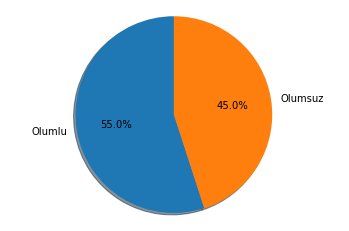

In [16]:
labels = twst.tweets.label.map({1:'Olumlu',0:'Olumsuz'}).value_counts().index.values
sizes = twst.tweets.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [17]:
data = twst.tweets.copy()

In [18]:
def preProcess(ReviewText):
    #Verideki <br> taglarını kaldır.
    ReviewText = ReviewText.str.lower()
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ') 
    #Verideki Linkleri Kaldır.
    ReviewText = ReviewText.str.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText

data['Text'] = preProcess(data['Text'])

In [19]:
# Kök Bulma
stemmer = TurkishStemmer()

stemmed_lists = []
for index in tqdm(data.index):
    mini_l = []
    for text in data.loc[index]['Text'].split(" "):
        mini_l.append(stemmer.stem(text))

    big_text=" "
    for char in mini_l:
        big_text = big_text + " " + char
    stemmed_lists.append(big_text)
    
data['stemmed'] = stemmed_lists

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2053.61it/s]


In [20]:
data.head()

,Tarih,Tweet_id,Text,label,score,stemmed
0,2021-09-06 21:33:10,1434993097939771398,"rt @tubaparody: o kadar yangın çıktı, sel oldu...",0,0.994194,"rt @tubaparody: o kadar yang çıktı, sel oldu..."
1,2021-09-06 21:32:46,1434992997419081728,@kriptoemre 128 milyar dolar 😇,1,0.989131,@kriptoemre 128 milyar do 😇
2,2021-09-06 21:32:29,1434992927038640128,"rt @__testere_____: giriş:\ni̇şte, bütün serve...",1,0.847251,"rt @__testere_____: giriş:\ni̇şte, bütün ser..."
3,2021-09-06 21:32:29,1434992926040498182,"@kriptoemre parayla zaman satın alınmazki, 5mi...",1,0.567592,"@kriptoemre para zaman sat alınmazki, 5milyo..."
4,2021-09-06 21:32:19,1434992887771639812,@allbeganoneday süper 2 dolar olck,1,0.965940,@allbeganoneday süper 2 do olck


In [22]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

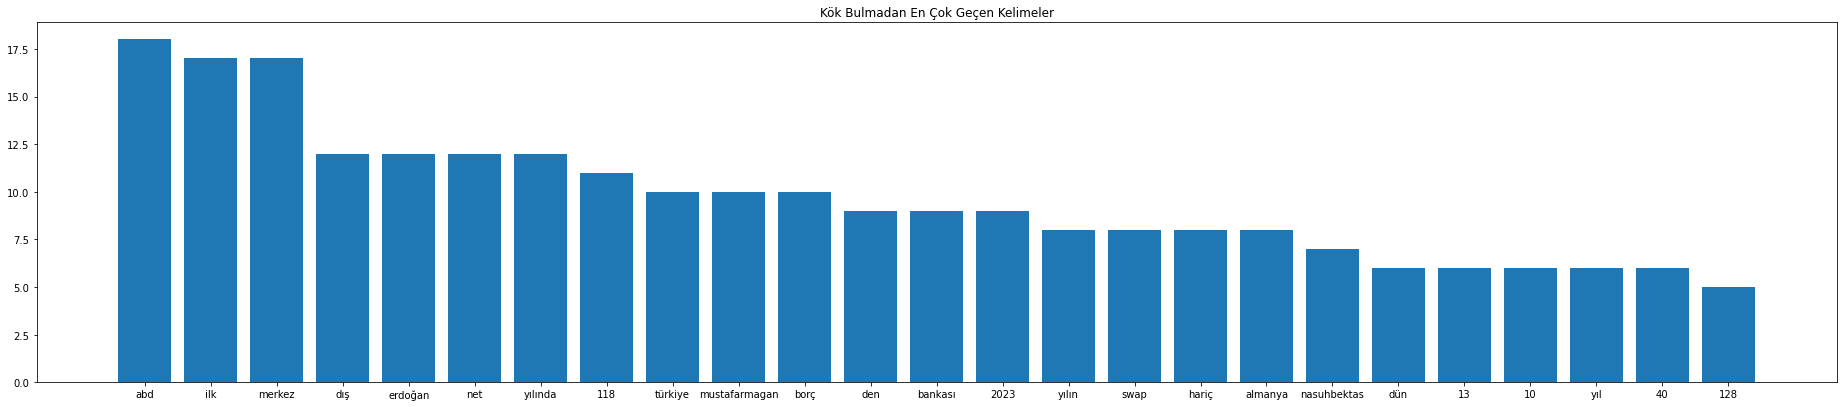

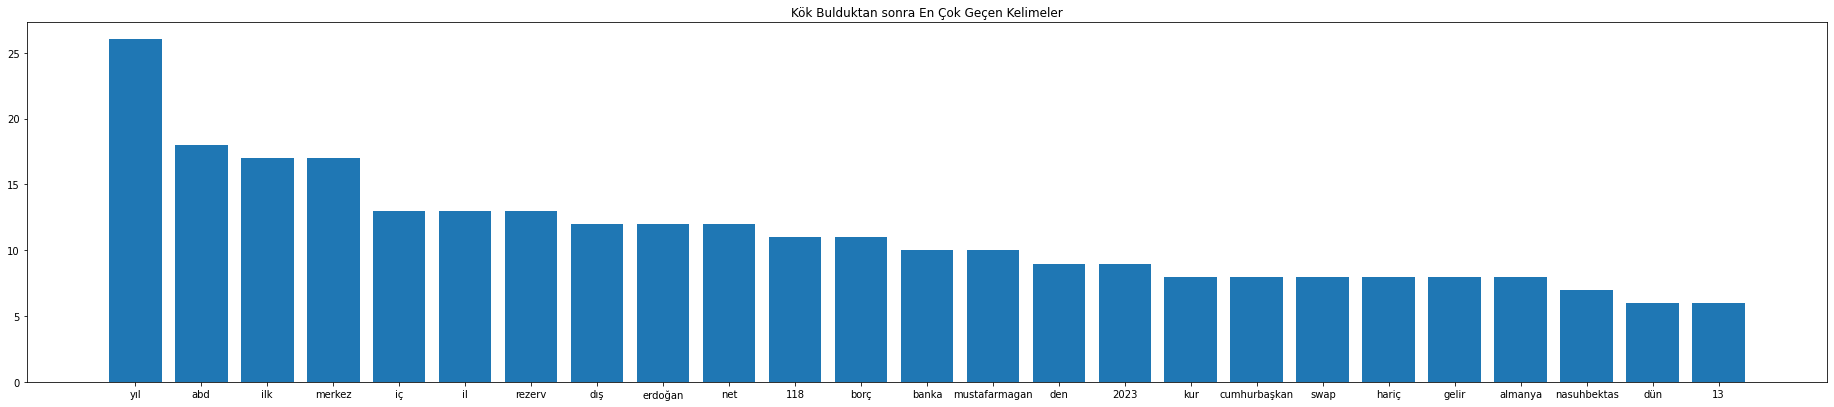

In [23]:
common_words = get_top_n_words(data['Text'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulmadan En Çok Geçen Kelimeler')
plt.show()


common_words = get_top_n_words(data['stemmed'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.title('Kök Bulduktan sonra En Çok Geçen Kelimeler')
plt.show()

# Kök Bulmadan Wordcloud

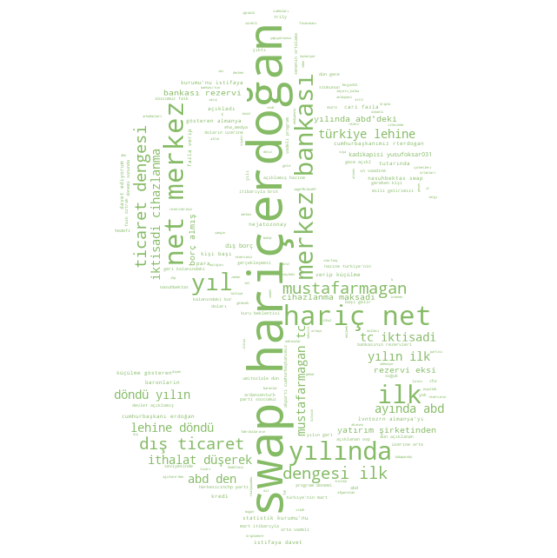

In [24]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.Text)

wine_mask = np.array(Image.open(requests.get("https://raw.githubusercontent.com/kaveai/veribilimiyazokulu/main/Python%20ve%20Veri%20Bilimi%20%C3%96rnekleri/dolar.jpg", stream=True).raw))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Kök bulduktan sonra wordcloud

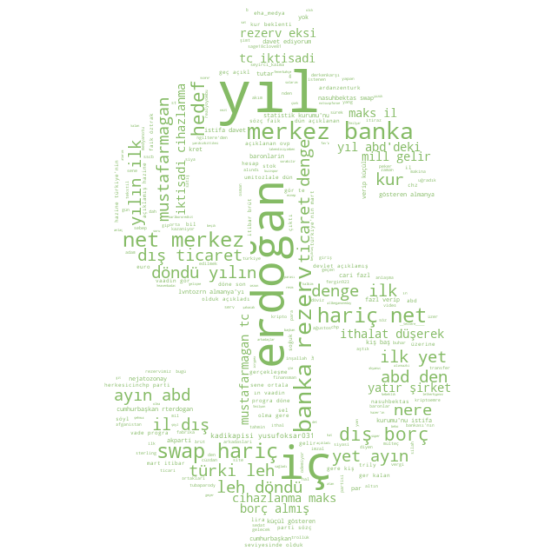

In [25]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "#85bb65"

text = " ".join(review for review in data.stemmed)

wine_mask = np.array(Image.open(requests.get("https://raw.githubusercontent.com/kaveai/veribilimiyazokulu/main/Python%20ve%20Veri%20Bilimi%20%C3%96rnekleri/dolar.jpg", stream=True).raw))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()